In [1]:
import sys
sys.path.append("../")

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-01 21:35:05.241529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
calc_train_dataset = pd.read_csv("../dataset/csv/calc_case_description_train_set.csv")
calc_test_dataset = pd.read_csv("../dataset/csv/calc_case_description_test_set.csv")
dicom_dataset = pd.read_csv("../dataset/csv/dicom_info.csv")

In [4]:
image_paths = calc_train_dataset["image file path"].values
patient_ids = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    patient_ids.append(path.split(os.sep)[0])
    
calc_train_dataset["PatientID"] = patient_ids

In [5]:
image_paths = calc_test_dataset["image file path"].values
patient_ids = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    patient_ids.append(path.split(os.sep)[0])

calc_test_dataset["PatientID"] = patient_ids

In [6]:
calc_train_dataset = calc_train_dataset.merge(dicom_dataset[["PatientID", "image_path"]], on='PatientID', how='inner')
calc_test_dataset = calc_test_dataset.merge(dicom_dataset[["PatientID", "image_path"]], on='PatientID', how='inner')

In [7]:
image_paths = calc_train_dataset["image_path"].values
image_cropped_paths = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    x = path.split(os.sep)
    x[0] = "../dataset"
    image_cropped_paths.append(os.path.join(*x))
    
calc_train_dataset["fixed_image_paths"] = image_cropped_paths

In [8]:
image_paths = calc_test_dataset["image_path"].values
image_cropped_paths = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    x = path.split(os.sep)
    x[0] = "../dataset"
    image_cropped_paths.append(os.path.join(*x))
    
calc_test_dataset["fixed_image_paths"] = image_cropped_paths

## Creating unprocessed dataset

In [9]:
new_dataset_train_path = "../calc_dataset/train/"
new_dataset_val_path = "../calc_dataset/validation/"

if not os.path.exists(new_dataset_train_path):
    os.makedirs(new_dataset_train_path+'MALIGNANT')
    os.makedirs(new_dataset_train_path+'BENIGN')
if not os.path.exists(new_dataset_val_path):
    os.makedirs(new_dataset_val_path+'MALIGNANT')
    os.makedirs(new_dataset_val_path+'BENIGN')

In [10]:
train_dataset = calc_train_dataset[["PatientID",
                                    "pathology",
                                    "fixed_image_paths"]].loc[calc_train_dataset['pathology'].isin(["MALIGNANT",
                                                                                                    "BENIGN"])]

test_dataset = calc_test_dataset[["PatientID",
                                  "pathology", 
                                  "fixed_image_paths"]].loc[calc_test_dataset['pathology'].isin(["MALIGNANT", 
                                                                                                 "BENIGN"])]

In [13]:
images = []
for p_id, label, image_path in train_dataset.values:
    image = cv2.imread(image_path, 0)
    save_dir = os.path.join(new_dataset_train_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

In [14]:
for p_id, label, image_path in test_dataset.values:
    image = cv2.imread(image_path, 0)
    save_dir = os.path.join(new_dataset_val_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

## Creating preprocessed dataset

In [15]:
new_dataset_train_path = "../calc_preprocess_dataset/train/"
new_dataset_val_path = "../calc_preprocess_dataset/validation/"

if not os.path.exists(new_dataset_train_path):
    os.makedirs(new_dataset_train_path+'MALIGNANT')
    os.makedirs(new_dataset_train_path+'BENIGN')
if not os.path.exists(new_dataset_val_path):
    os.makedirs(new_dataset_val_path+'MALIGNANT')
    os.makedirs(new_dataset_val_path+'BENIGN')

In [18]:
images = []
clahe=cv2.createCLAHE(clipLimit=40)

for p_id, label, image_path in train_dataset.values:
    image = cv2.imread(image_path, 0)
    gray_img_eqhist=cv2.equalizeHist(image)
    gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
    image = tf.image.resize(gray_clahe_image, (229, 229)).numpy().astype("uint8")
    save_dir = os.path.join(new_dataset_train_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

2023-05-01 21:35:07.571908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 21:35:07.573813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [19]:
for p_id, label, image_path in test_dataset.values:
    image = cv2.imread(image_path, 0)
    gray_img_eqhist=cv2.equalizeHist(image)
    gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
    image = tf.image.resize(gray_clahe_image, (229, 229)).numpy().astype("uint8")
    save_dir = os.path.join(new_dataset_val_path, label, p_id+'.jpg')
    cv2.imwrite(save_dir, image)

In [32]:
calc_train_dataset

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,PatientID,image_path,fixed_image_paths
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.474143...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.47414...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250596...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.25059...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228699...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.22869...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104743...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.10474...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406725...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.40672...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,P_02566,2,RIGHT,MLO,1,calcification,AMORPHOUS-PLEOMORPHIC,SEGMENTAL,5,MALIGNANT,5,Calc-Training_P_02566_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_02566_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_02566_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_02566_RIGHT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215164...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.21516...
1542,P_02572,2,LEFT,CC,1,calcification,AMORPHOUS,CLUSTERED,0,MALIGNANT,2,Calc-Training_P_02572_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_02572_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02572_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02572_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.398227...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.39822...
1543,P_02572,2,LEFT,MLO,1,calcification,AMORPHOUS,CLUSTERED,0,MALIGNANT,2,Calc-Training_P_02572_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_02572_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_02572_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_02572_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.832140...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.83214...
1544,P_02584,1,LEFT,CC,1,calcification,PLEOMORPHIC,SEGMENTAL,0,BENIGN,4,Calc-Training_P_02584_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_02584_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02584_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_02584_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.114030...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.11403...


In [33]:
dicom_dataset[["PatientID","SeriesDescription"]]

,PatientID,SeriesDescription
0,Mass-Training_P_01265_RIGHT_MLO_1,cropped images
1,Mass-Training_P_01754_RIGHT_CC,full mammogram images
2,Calc-Training_P_00232_RIGHT_CC,full mammogram images
3,Calc-Test_P_00562_LEFT_CC_2,cropped images
4,P_00562_LEFT_CC_2.dcm,NaN
...,...,...
10232,Calc-Training_P_01864_RIGHT_CC_2,ROI mask images
10233,Mass-Test_P_00979_LEFT_MLO,full mammogram images
10234,Mass-Training_P_01461_RIGHT_MLO,full mammogram images
10235,Mass-Training_P_00314_RIGHT_MLO_1,ROI mask images


In [34]:
dicom_dataset[["image_path", "PatientID"]][dicom_dataset["SeriesDescription"] == "cropped images"]

,image_path,PatientID
0,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,Mass-Training_P_01265_RIGHT_MLO_1
3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,Calc-Test_P_00562_LEFT_CC_2
6,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,Calc-Training_P_00181_RIGHT_CC_1
7,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,Calc-Training_P_01015_LEFT_CC_1
10,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...,Calc-Training_P_01497_LEFT_CC_1
...,...,...
10225,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374221...,Calc-Training_P_00448_LEFT_MLO_1
10227,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195242...,Mass-Training_P_01559_RIGHT_MLO_1
10229,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263713...,Mass-Training_P_00731_RIGHT_CC_1
10231,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.627982...,Calc-Training_P_01864_RIGHT_CC_2


In [35]:
calc_train_dataset[calc_train_dataset["patient_id"] == "P_01497"]

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,PatientID,image_path,fixed_image_paths
1184,P_01497,4,LEFT,CC,1,calcification,PUNCTATE-AMORPHOUS,REGIONAL,4,BENIGN,3,Calc-Training_P_01497_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_01497_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_01497_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_01497_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.350546...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.35054...
1185,P_01497,4,LEFT,MLO,1,calcification,PUNCTATE-AMORPHOUS,REGIONAL,4,BENIGN,3,Calc-Training_P_01497_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_01497_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_01497_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_01497_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.220280...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.22028...
1186,P_01497,4,RIGHT,MLO,1,calcification,PUNCTATE-AMORPHOUS,REGIONAL,4,BENIGN,3,Calc-Training_P_01497_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_01497_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_01497_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_01497_RIGHT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.683599...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.68359...


In [41]:
x = dicom_dataset[["image_path", "SeriesDescription"]][dicom_dataset["PatientID"] == "Calc-Training_P_01497_LEFT_CC_1"]

In [42]:
x.values

array([['CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg',
        'ROI mask images'],
       ['CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg',
        'cropped images']], dtype=object)

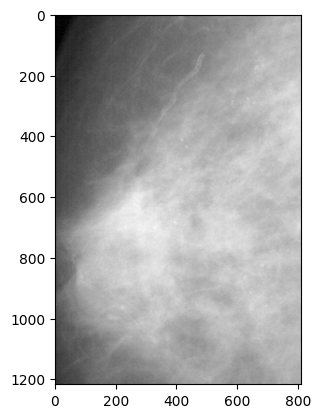

In [44]:
im = cv2.imread('../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/1-003.jpg')
plt.imshow(im)

In [ ]:
im

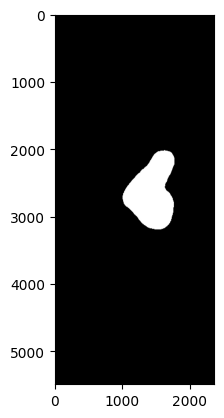

In [74]:
roi = cv2.imread('../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg')
plt.imshow(roi)

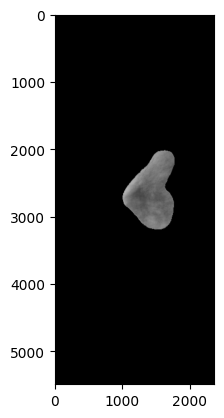

In [76]:
im = cv2.imread('../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.350546038712624038408433082083902639722/1-106.jpg')
plt.imshow(im*roi)

In [68]:
roi.shape

(1217, 809, 3)